### Import main functions

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import os, copy
%matplotlib inline

imw = 192
imh = 192
c = 1
RS = 2211

In [0]:
import seaborn as sns
import matplotlib.patheffects as PathEffects

In [ ]:
from plot_helpers import show_image, plot_tsne
from dataset_helpers import is_dmso, get_label
from dataset_helpers import low_clip, mean_clip, low_clip, minmax

In [4]:
from sklearn.manifold import TSNE
import umap
from keras.layers import Input, BatchNormalization, Dense, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Flatten, Reshape, LeakyReLU
from keras.models import Model
from keras import backend as K

Using TensorFlow backend.


In [0]:
def unishuffle(a, b, random_state=RS):
    assert len(a) == len(b)
    if random_state:
        np.random.seed(RS)
    p = np.random.permutation(len(a))
    return a[p], b[p]

### Read dataset

In [0]:
npzfile = np.load('/Users/Leonore/Desktop/dmso_unmodified.npz')

In [0]:
y = npzfile['y']

In [0]:
y_dmso = np.array([get_label(i) for i in y])

### Helper functions for evaluating model

In [0]:
plt.rcParams.update({'axes.titlesize': 'medium'})

def run_evaluation(model, data, test, batch_size=48, epochs=30, visualise=False):
    # visualise feature maps
    if visualise:
        visualise_activations(model, data)
    
    # get model image predictions before training
    # @QUESTION: is this a good strategy?
    decoded_before = model.predict(data[21:22])
    test_decoded_before = model.predict(test[21:22])

    # fit model; get before/after weights (make sure there is a change)
    untrained_weights = [np.min(model.get_layer(index=1).get_weights()[0]), np.max(model.get_layer(index=1).get_weights()[0])]
    loss = model.fit(data, data, epochs=epochs, batch_size=batch_size)
    trained_weights = [np.min(model.get_layer(index=1).get_weights()[0]), np.max(model.get_layer(index=1).get_weights()[0])]
    
    # plot the loss
    plt.figure()
    plt.plot(loss.history['loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    
    
    # show the difference in reconstruction
    decoded_imgs = model.predict(data[21:22]) # test on images it trained on
    untrained_decoded = model.predict(test[21:22]) # test images

    s=12
    fig = plt.figure(figsize=(s,s))
    fig.add_subplot(1, 3, 1)
    show_image(reshape(data[21], w=imw, h=imh, c=c), "original training image")
    fig.add_subplot(1, 3, 2)
    show_image(reshape(decoded_imgs[0], w=imw, h=imh, c=c), "reconstructed - after")
    fig.add_subplot(1, 3, 3)
    show_image(reshape(decoded_before[0], w=imw, h=imh, c=c), "reconstructed - before")

    fig = plt.figure(figsize=(s,s))
    fig.add_subplot(1, 3, 1)
    show_image(reshape(test[21], w=imw, h=imh, c=c), "original test image")
    fig.add_subplot(1, 3, 2)
    show_image(reshape(untrained_decoded[0], w=imw, h=imh, c=c), "reconstructed test - after")
    fig.add_subplot(1, 3, 3)
    show_image(reshape(test_decoded_before[0], w=imw, h=imh, c=c), "reconstructed test - before")
              
    # see if weights have changed
    print("Weight difference: {}".format(np.array(untrained_weights)-np.array(trained_weights)))

In [0]:
# credit: https://github.com/gabrielpierobon/cnnshapes/blob/master/README.md

def visualise_activations(model, images):
    idx = np.random.randint(1, len(images)+1)
    l = len(model.layers)
    layer_outputs = [layer.output for layer in model.layers[1:l]]
    activation_model = Model(inputs=model.input, outputs=layer_outputs)
    # Choose random image to predict for
    activations = activation_model.predict(images[idx-1:idx])

    layer_names = []
    for layer in model.layers[1:l]:
        layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot

    images_per_row = 16

    for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
        n_features = layer_activation.shape[-1] # Number of features in the feature map
        size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
        n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols): # Tiles each filter into a big horizontal grid
            for row in range(images_per_row):
                channel_image = layer_activation[0,
                                              :, :,
                                              col * images_per_row + row]
                channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 65535).astype('uint16')
                display_grid[col * size : (col + 1) * size, # Displays the grid
                          row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                          scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='gray')

## DMSO dataset, 16-bit normalised

In [0]:
X = npzfile['x']
x_dmso = np.reshape(X, (len(X), imw, imh))

In [0]:
for idx, i in enumerate(x_dmso):
    x_dmso[idx] = i / 65535.0
x_train, y_train = unishuffle(x_dmso, y_dmso)
x_train = np.reshape(x_train, (len(x_train), imw, imh, 1))

In [0]:
input_img = Input(shape=(imw, imh, c))

x = Conv2D(32, (3, 3), padding='same')(input_img)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), padding='same')(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), padding='same')(x)
x = LeakyReLU()(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(8, (3, 3), padding='same')(encoded)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), padding='same')(x)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), padding="same")(x)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(c, (3, 3), activation='sigmoid', padding='same')(x)

In [0]:
decoder = Model(input_img, decoded)
decoder.compile(optimizer='adam', loss='binary_crossentropy')









Epoch 1/10
19400/19400 [==============================] - 65s 3ms/step - loss: 0.0700
Epoch 2/10
19400/19400 [==============================] - 63s 3ms/step - loss: 0.0309
Epoch 3/10
19400/19400 [==============================] - 63s 3ms/step - loss: 0.0302
Epoch 4/10
19400/19400 [==============================] - 63s 3ms/step - loss: 0.0301
Epoch 5/10
19400/19400 [==============================] - 63s 3ms/step - loss: 0.0301
Epoch 6/10
19400/19400 [==============================] - 63s 3ms/step - loss: 0.0301
Epoch 7/10
19400/19400 [==============================] - 62s 3ms/step - loss: 0.0301
Epoch 8/10
19400/19400 [==============================] - 63s 3ms/step - loss: 0.0300
Epoch 9/10
19400/19400 [==============================] - 63s 3ms/step - loss: 0.0300
Epoch 10/10
19400/19400 [==============================] - 63s 3ms/step - loss: 0.0300
Weight difference: [ 0.21987458 -0.23275827]


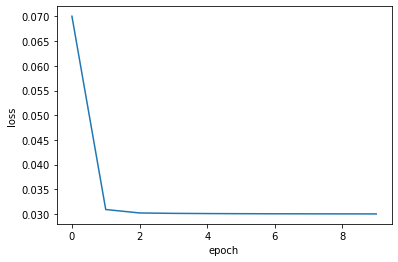

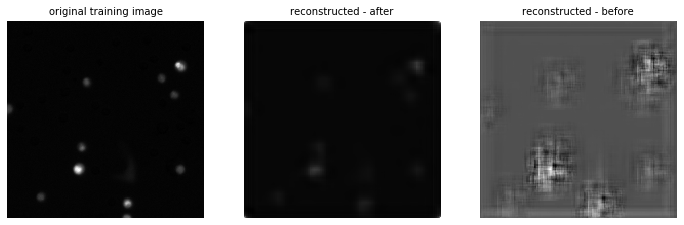

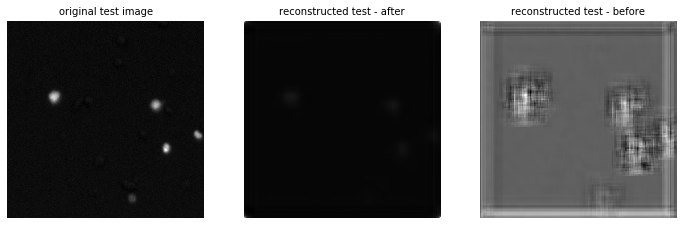

In [21]:
run_evaluation(decoder, x_train[:-200], x_train[-200:], batch_size=64, epochs=10)

## DMSO dataset, max normalised

In [0]:
X = npzfile['x']
x_dmso = np.reshape(X, (len(X), imw, imh))

In [0]:
for idx, i in enumerate(x_dmso):
    x_dmso[idx] = max_normalise(i)

In [0]:
x_train, y_train = unishuffle(x_dmso, y_dmso)

In [0]:
c = 1

In [0]:
input_img = Input(shape=(imw, imh, c))

x = Conv2D(32, (3, 3), padding='same')(input_img)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), padding='same')(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), padding='same')(x)
x = LeakyReLU()(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(8, (3, 3), padding='same')(encoded)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), padding='same')(x)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), padding="same")(x)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(c, (3, 3), activation='sigmoid', padding='same')(x)

In [0]:
decoder = Model(input_img, decoded)
decoder.compile(optimizer='adam', loss='binary_crossentropy')


In [0]:
x_train = np.reshape(x_train, (len(x_train), imw, imh, 1))

Epoch 1/10
19400/19400 [==============================] - 64s 3ms/step - loss: 0.5112
Epoch 2/10
19400/19400 [==============================] - 63s 3ms/step - loss: 0.4946
Epoch 3/10
19400/19400 [==============================] - 63s 3ms/step - loss: 0.4938
Epoch 4/10
19400/19400 [==============================] - 63s 3ms/step - loss: 0.4937
Epoch 5/10
19400/19400 [==============================] - 63s 3ms/step - loss: 0.4936
Epoch 6/10
19400/19400 [==============================] - 63s 3ms/step - loss: 0.4935
Epoch 7/10
19400/19400 [==============================] - 63s 3ms/step - loss: 0.4934
Epoch 8/10
19400/19400 [==============================] - 63s 3ms/step - loss: 0.4934
Epoch 9/10
19400/19400 [==============================] - 63s 3ms/step - loss: 0.4934
Epoch 10/10
19400/19400 [==============================] - 63s 3ms/step - loss: 0.4933
Weight difference: [ 0.01654965 -0.04896037]


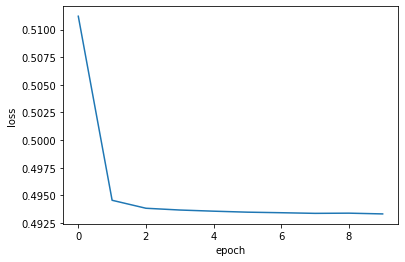

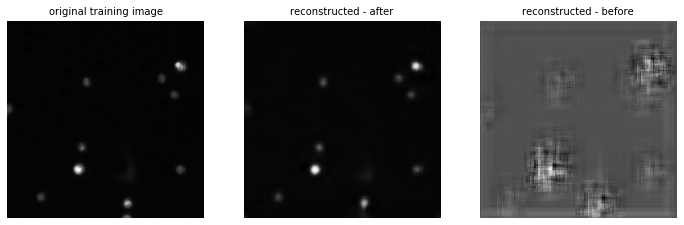

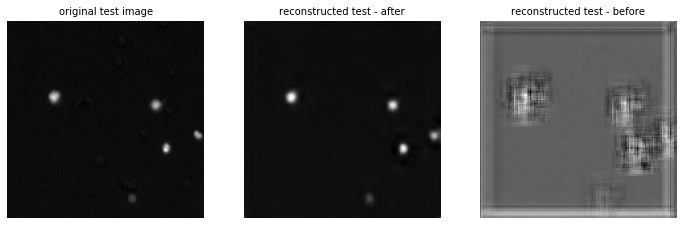

In [29]:
run_evaluation(decoder, x_train[:-200], x_train[-200:], batch_size=64, epochs=10)

In [0]:
encoder = Model(input_img, encoded)
encoded_imgs = encoder.predict(x_train)
encoded = np.reshape(encoded_imgs, (len(encoded_imgs), 24*24*8))

In [0]:
x_tsne = TSNE(random_state=RS, perplexity=5, learning_rate=200, n_iter=2500).fit_transform(encoded[:500])

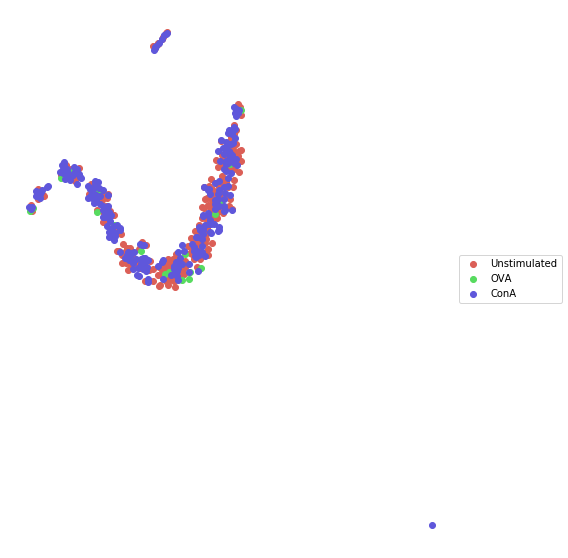

In [32]:
plot_tsne(x_tsne, y_train[:500])

In [0]:
x_umap = umap.UMAP(random_state=RS).fit_transform(encoded[:500])

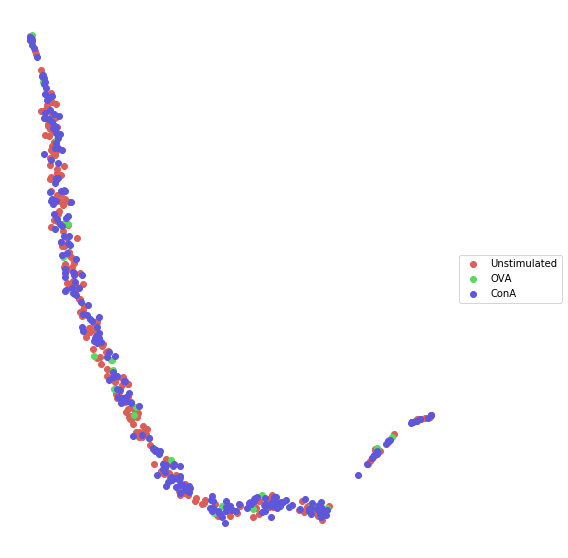

In [34]:
plot_tsne(x_umap, y_train[:500])

## DMSO dataset, max normalised, mean clipping

In [0]:
X = npzfile['x']
x_dmso_mean = np.reshape(X, (len(X), imw, imh))

In [0]:
for idx, i in enumerate(x_dmso):
    x_dmso_mean[idx] = max_normalise(mean_clip(i))

In [0]:
x_train, y_train = unishuffle(x_dmso_mean, y_dmso)

In [0]:
input_img = Input(shape=(imw, imh, c))

x = Conv2D(32, (3, 3), padding='same')(input_img)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), padding='same')(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), padding='same')(x)
x = LeakyReLU()(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(8, (3, 3), padding='same')(encoded)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), padding='same')(x)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), padding="same")(x)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(c, (3, 3), activation='sigmoid', padding='same')(x)

In [0]:
decoder = Model(input_img, decoded)
decoder.compile(optimizer='adam', loss='binary_crossentropy')

In [0]:
x_train = np.reshape(x_train, (len(x_train), imw, imh, 1))

Epoch 1/10
19000/19000 [==============================] - 64s 3ms/step - loss: 0.5113
Epoch 2/10
19000/19000 [==============================] - 62s 3ms/step - loss: 0.4945
Epoch 3/10
19000/19000 [==============================] - 62s 3ms/step - loss: 0.4938
Epoch 4/10
19000/19000 [==============================] - 62s 3ms/step - loss: 0.4937
Epoch 5/10
19000/19000 [==============================] - 62s 3ms/step - loss: 0.4936
Epoch 6/10
19000/19000 [==============================] - 62s 3ms/step - loss: 0.4935
Epoch 7/10
19000/19000 [==============================] - 62s 3ms/step - loss: 0.4935
Epoch 8/10
19000/19000 [==============================] - 62s 3ms/step - loss: 0.4934
Epoch 9/10
19000/19000 [==============================] - 62s 3ms/step - loss: 0.4934
Epoch 10/10
19000/19000 [==============================] - 62s 3ms/step - loss: 0.4934
Weight difference: [ 0.01824301 -0.04110189]


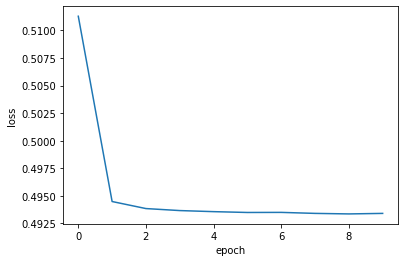

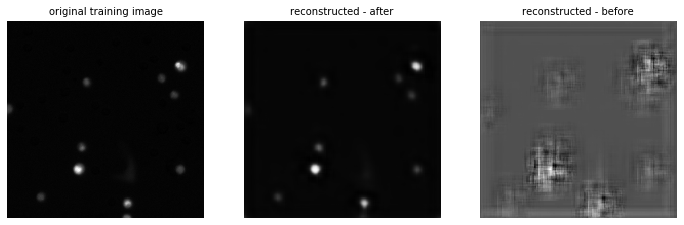

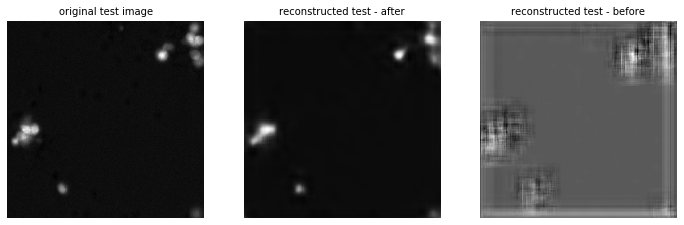

In [41]:
run_evaluation(decoder, x_train[:19000], x_train[19000:], batch_size=64, epochs=10)

In [0]:
encoder = Model(input_img, encoded)
encoded_imgs = encoder.predict(x_train)
encoded = np.reshape(encoded_imgs, (len(encoded_imgs), 24*24*8))

In [0]:
x_tsne = TSNE(random_state=RS, perplexity=5, learning_rate=200, n_iter=2500).fit_transform(encoded[:500])

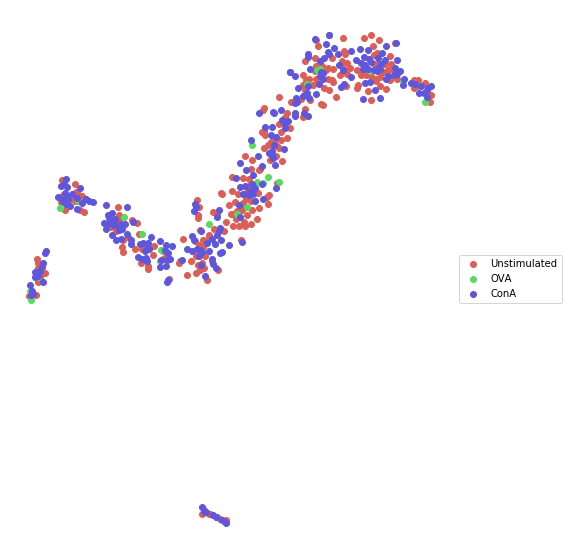

In [44]:
plot_tsne(x_tsne, y_train[:500])

In [0]:
x_umap = umap.UMAP(random_state=RS).fit_transform(encoded[:500])

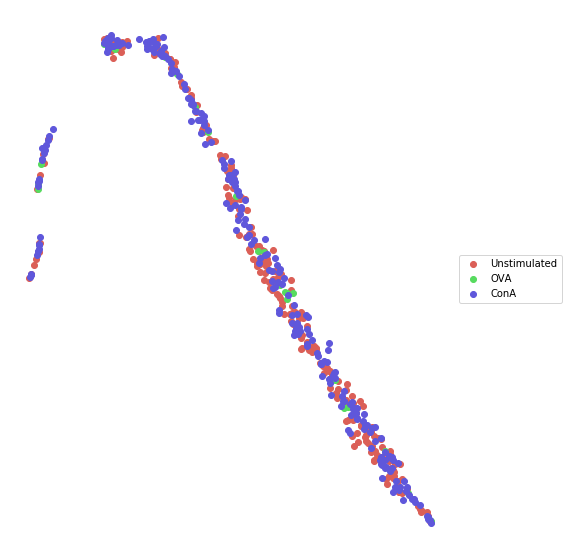

In [46]:
plot_tsne(x_umap, y_train[:500])

## DMSO dataset, max normalised, mean clipping, combined

In [0]:
X = npzfile['x']
x_dmso_mc = np.reshape(X, (len(X), imw, imh))

In [0]:
c = 3

In [0]:
idx = 0
j = 0
x_mc = np.ndarray(shape=(len(x_dmso_mc)//2, 192, 192, c))
y_mc = np.ndarray(shape=(len(y_dmso)//2))
while idx < (len(x_dmso_mc)):
  if (idx % 100 == 0) and (idx % 200 != 0):
    idx += 100
  else:
    tcell = max_normalise(mean_clip(x_dmso_mc[idx]))
    dcell = max_normalise(mean_clip(x_dmso_mc[idx+100]))
    x_mc[j, :, :, 0] = dcell
    x_mc[j, :, :, 1] = tcell
    y_mc[j] = y_dmso[idx]
    idx+=1
    j+=1

In [0]:
x_train, y_train = unishuffle(x_mc, y_mc)
x_train = np.reshape(x_train, (len(x_train), imw, imh, c))

In [20]:
input_img = Input(shape=(imw, imh, c))

x = Conv2D(32, (3, 3), padding='same')(input_img)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), padding='same')(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), padding='same')(x)
x = LeakyReLU()(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(8, (3, 3), padding='same')(encoded)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), padding='same')(x)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), padding="same")(x)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(c, (3, 3), activation='sigmoid', padding='same')(x)

In [21]:
decoder = Model(input_img, decoded)
decoder.compile(optimizer='adam', loss='binary_crossentropy')



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where










Epoch 1/10
9600/9600 [==============================] - 48s 5ms/step - loss: 2208273355250510.5000
Epoch 2/10
9600/9600 [==============================] - 46s 5ms/step - loss: 2208273355250510.5000
Epoch 3/10
9600/9600 [==============================] - 46s 5ms/step - loss: 2208273355250510.5000
Epoch 4/10
9600/9600 [==============================] - 46s 5ms/step - loss: 2194001007127211.2500
Epoch 5/10
9600/9600 [==============================] - 46s 5ms/step - loss: 2201725534442182.2500
Epoch 6/10
9600/9600 [==============================] - 46s 5ms/step - loss: 2202701351011833.7500
Epoch 7/10
9600/9600 [==============================] - 46s 5ms/step - loss: 2189798811124804.7500
Epoch 8/10
9600/9600 [==============================] - 46s 5ms/step - loss: 2159417930459818.7500
Epoch 9/10
9600/9600 [==============================] - 46s 5ms/step - loss: 2056999338592174.5000
Epoch 10/10
9600/9600 [==============================] - 45s 5ms/step - loss: 1987353752374695.5000
W

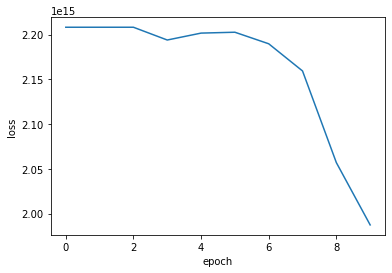

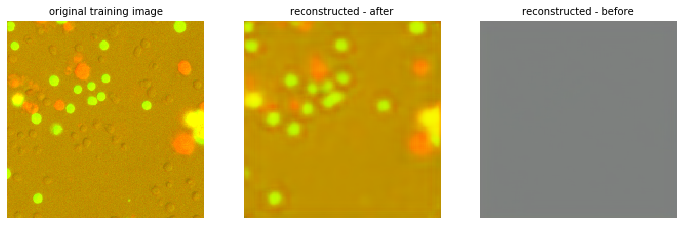

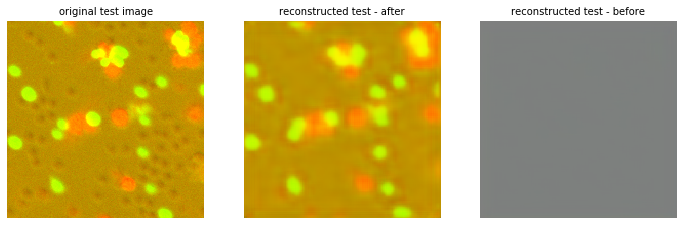

In [22]:
run_evaluation(decoder, x_train[:-200], x_train[-200:], batch_size=64, epochs=10)

In [0]:
encoder = Model(input_img, encoded)
encoded_imgs = encoder.predict(x_train)
encoded = np.reshape(encoded_imgs, (len(encoded_imgs), 24*24*8))

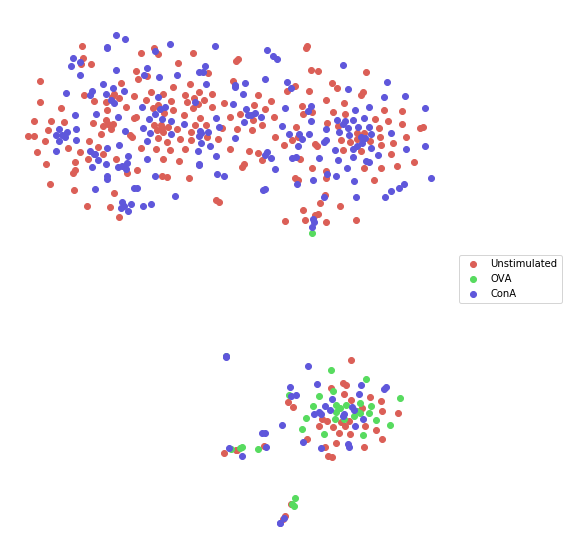

In [24]:
x_tsne = TSNE(random_state=RS, perplexity=5, learning_rate=200, n_iter=2500).fit_transform(encoded[:500])
plot_tsne(x_tsne, y_train[:500])

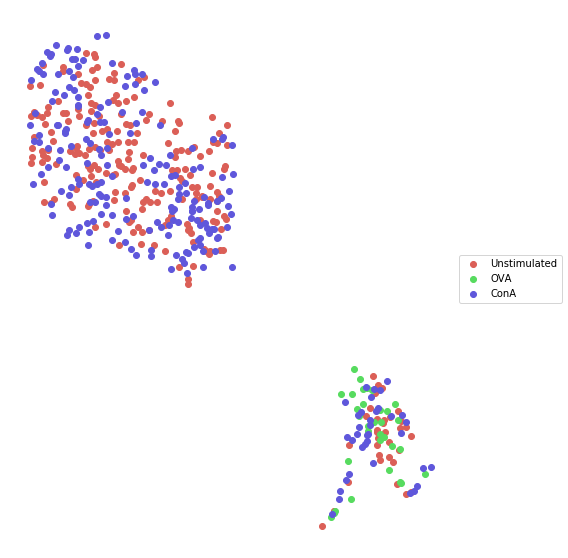

In [25]:
x_umap = umap.UMAP(random_state=RS).fit_transform(encoded[:500])
plot_tsne(x_umap, y_train[:500])

## DMSO dataset, minmax normalised, mean clipped, combined

In [0]:
X = npzfile['x']

In [0]:
c = 3

In [0]:
idx = 0
j = 0
x_mmc = np.ndarray(shape=(len(X)//2, 192, 192, c))
y_mmc = np.ndarray(shape=(len(X)//2))
while idx < (len(X)):
  if (idx % 100 == 0) and (idx % 200 != 0):
    idx += 100
  else:
    x_mmc[j, :, :, 0] = minmax(mean_clip(X[idx]))
    x_mmc[j, :, :, 1] = minmax(mean_clip(X[idx+100]))
    y_mmc[j] = y_dmso[idx]
    idx+=1
    j+=1

In [0]:
x_train, y_train = unishuffle(x_mmc, y_mmc)

In [0]:
input_img = Input(shape=(imw, imh, c))

x = Conv2D(32, (3, 3), padding='same')(input_img)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), padding='same')(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), padding='same')(x)
x = LeakyReLU()(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(8, (3, 3), padding='same')(encoded)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), padding='same')(x)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), padding="same")(x)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(c, (3, 3), activation='sigmoid', padding='same')(x)

In [0]:
decoder = Model(input_img, decoded)
decoder.compile(optimizer='adam', loss='binary_crossentropy')









Epoch 1/10
9600/9600 [==============================] - 48s 5ms/step - loss: 2559469280538133.0000
Epoch 2/10
9600/9600 [==============================] - 45s 5ms/step - loss: 2559469280538132.5000
Epoch 3/10
9600/9600 [==============================] - 46s 5ms/step - loss: 2559469280538132.5000
Epoch 4/10
9600/9600 [==============================] - 45s 5ms/step - loss: 2559469280538133.0000
Epoch 5/10
9600/9600 [==============================] - 46s 5ms/step - loss: 2559469280538133.0000
Epoch 6/10
9600/9600 [==============================] - 46s 5ms/step - loss: 2559469280538133.0000
Epoch 7/10
9600/9600 [==============================] - 46s 5ms/step - loss: 2559469280538133.0000
Epoch 8/10
9600/9600 [==============================] - 46s 5ms/step - loss: 2559469280538132.5000
Epoch 9/10
9600/9600 [==============================] - 46s 5ms/step - loss: 2559469280538133.0000
Epoch 10/10
9600/9600 [==============================] - 46s 5ms/step - loss: 2559469280538132.5000
W

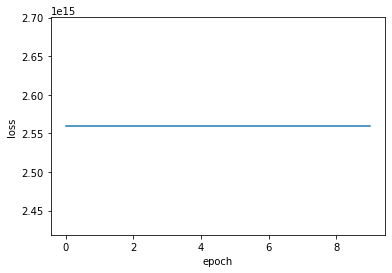

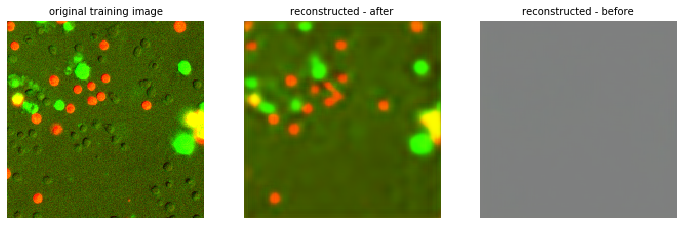

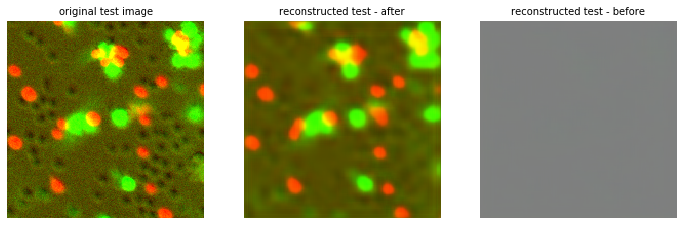

In [21]:
run_evaluation(decoder, x_train[:-200], x_train[-200:], batch_size=64, epochs=10)

In [0]:
encoder = Model(input_img, encoded)
encoded_imgs = encoder.predict(x_train)
encoded = np.reshape(encoded_imgs, (len(encoded_imgs), 24*24*8))

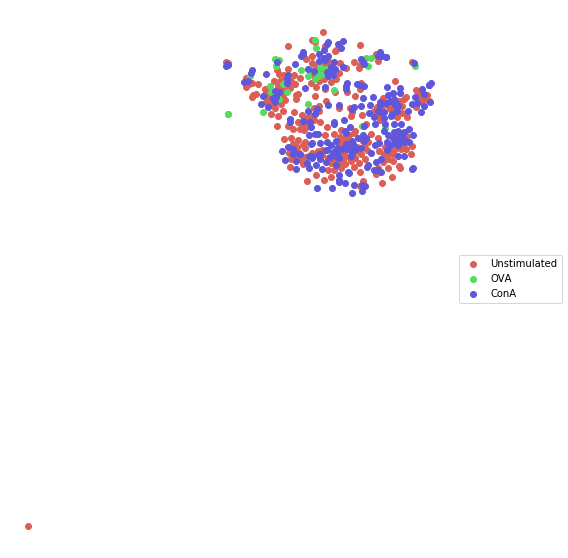

In [23]:
x_tsne = TSNE(random_state=RS, perplexity=5, learning_rate=200, n_iter=2500).fit_transform(encoded[:500])
plot_tsne(x_tsne, y_train[:500])

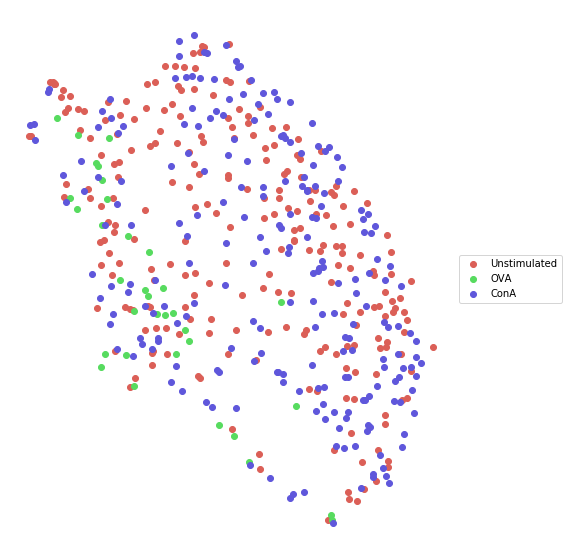

In [24]:
x_umap = umap.UMAP(random_state=RS).fit_transform(encoded[:500])
plot_tsne(x_umap, y_train[:500])

## DMSO dataset, max normalised, low clipped

In [0]:
c = 1

In [0]:
X = npzfile['x']
x_dmso_low = np.reshape(X, (len(X), imw, imh))

In [0]:
for idx, i in enumerate(x_dmso_low):
    x_dmso_low[idx] = max_normalise(low_clip(i))
x_train, y_train = unishuffle(x_dmso_low, y_dmso)
x_train = np.reshape(x_train, (len(x_train), imw, imh, c))

In [20]:
input_img = Input(shape=(imw, imh, c))

x = Conv2D(32, (3, 3), padding='same')(input_img)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), padding='same')(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), padding='same')(x)
x = LeakyReLU()(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(8, (3, 3), padding='same')(encoded)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), padding='same')(x)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), padding="same")(x)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(c, (3, 3), activation='sigmoid', padding='same')(x)

In [21]:
decoder = Model(input_img, decoded)
decoder.compile(optimizer='adam', loss='binary_crossentropy')



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where










Epoch 1/10
19400/19400 [==============================] - 64s 3ms/step - loss: 0.5454
Epoch 2/10
19400/19400 [==============================] - 61s 3ms/step - loss: 0.5318
Epoch 3/10
19400/19400 [==============================] - 62s 3ms/step - loss: 0.5312
Epoch 4/10
19400/19400 [==============================] - 62s 3ms/step - loss: 0.5311
Epoch 5/10
19400/19400 [==============================] - 62s 3ms/step - loss: 0.5310
Epoch 6/10
19400/19400 [==============================] - 62s 3ms/step - loss: 0.5306
Epoch 7/10
19400/19400 [==============================] - 62s 3ms/step - loss: 0.5305
Epoch 8/10
19400/19400 [==============================] - 62s 3ms/step - loss: 0.5305
Epoch 9/10
19400/19400 [==============================] - 62s 3ms/step - loss: 0.5303
Epoch 10/10
19400/19400 [==============================] - 61s 3ms/step - loss: 0.5304
Weight difference: [ 0.0156596  -0.03347349]


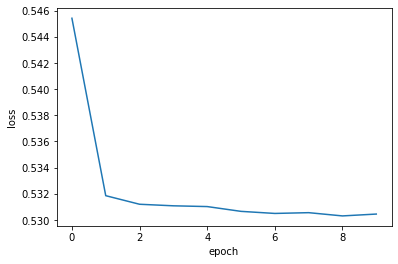

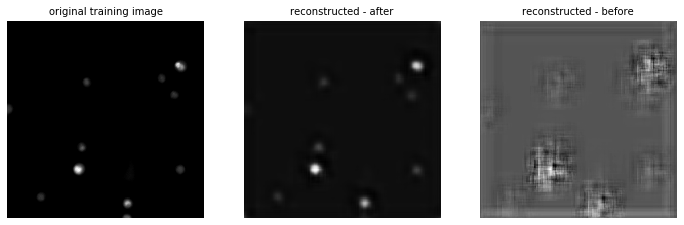

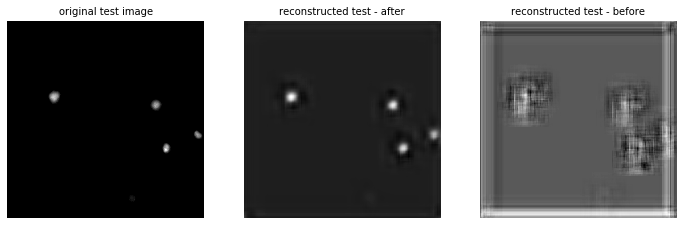

In [22]:
run_evaluation(decoder, x_train[:-200], x_train[-200:], batch_size=64, epochs=10)

In [0]:
encoder = Model(input_img, encoded)
encoded_imgs = encoder.predict(x_train)
encoded = np.reshape(encoded_imgs, (len(encoded_imgs), 24*24*8))

In [0]:
x_tsne = TSNE(random_state=RS, perplexity=5, learning_rate=200, n_iter=2500).fit_transform(encoded[:500])

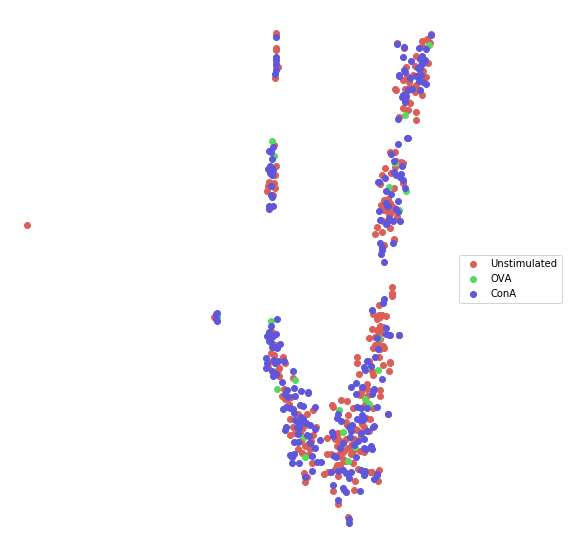

In [25]:
plot_tsne(x_tsne, y_train[:500])

In [0]:
x_umap = umap.UMAP(random_state=RS).fit_transform(encoded[:500])

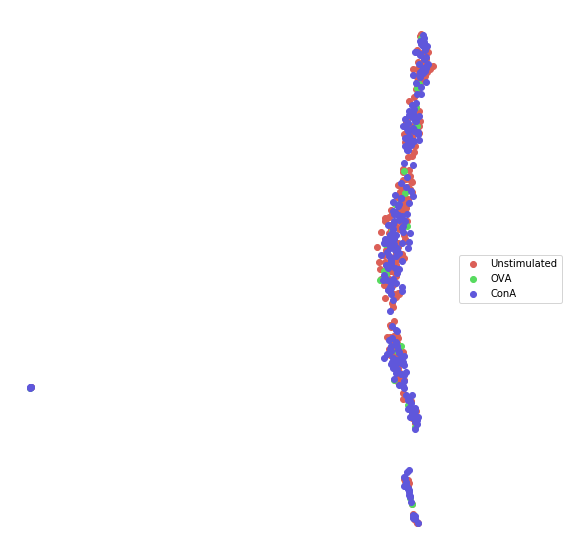

In [27]:
plot_tsne(x_umap, y_train[:500])

## DMSO dataset, max normalised, low clipped, combined

In [0]:
c = 3

In [0]:
X = npzfile['x']
x_dmso_lc = np.reshape(X, (len(X), imw, imh))

In [0]:
idx = 0
j = 0
x_lc = np.ndarray(shape=(len(x_dmso_lc)//2, 192, 192, c))
y_lc = np.ndarray(shape=(len(x_dmso_lc)//2))
while idx < (len(x_dmso_lc)):
  if (idx % 100 == 0) and (idx % 200 != 0):
    idx += 100
  else:
    x_lc[j, :, :, 0] = max_normalise(low_clip(x_dmso_lc[idx]))
    x_lc[j, :, :, 1] = max_normalise(low_clip(x_dmso_lc[idx+100]))
    y_lc[j] = y_dmso[idx]
    idx+=1
    j+=1

In [0]:
x_train, y_train = unishuffle(x_lc, y_lc)

In [0]:
input_img = Input(shape=(imw, imh, c))

x = Conv2D(32, (3, 3), padding='same')(input_img)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), padding='same')(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), padding='same')(x)
x = LeakyReLU()(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(8, (3, 3), padding='same')(encoded)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), padding='same')(x)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), padding="same")(x)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(c, (3, 3), activation='sigmoid', padding='same')(x)

In [0]:
decoder = Model(input_img, decoded)
decoder.compile(optimizer='adam', loss='binary_crossentropy')









Epoch 1/10
9600/9600 [==============================] - 47s 5ms/step - loss: 2559469280538132.5000
Epoch 2/10
9600/9600 [==============================] - 45s 5ms/step - loss: 2559469280538132.5000
Epoch 3/10
9600/9600 [==============================] - 45s 5ms/step - loss: 2559469280538132.5000
Epoch 4/10
9600/9600 [==============================] - 45s 5ms/step - loss: 2559469280538133.0000
Epoch 5/10
9600/9600 [==============================] - 45s 5ms/step - loss: 2559469280538132.5000
Epoch 6/10
9600/9600 [==============================] - 45s 5ms/step - loss: 2559469280538133.0000
Epoch 7/10
9600/9600 [==============================] - 46s 5ms/step - loss: 2559469280538133.0000
Epoch 8/10
9600/9600 [==============================] - 45s 5ms/step - loss: 2559469280538132.5000
Epoch 9/10
9600/9600 [==============================] - 45s 5ms/step - loss: 2559469280538133.0000
Epoch 10/10
9600/9600 [==============================] - 45s 5ms/step - loss: 2559469280538132.5000
W

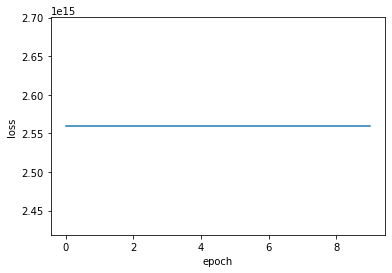

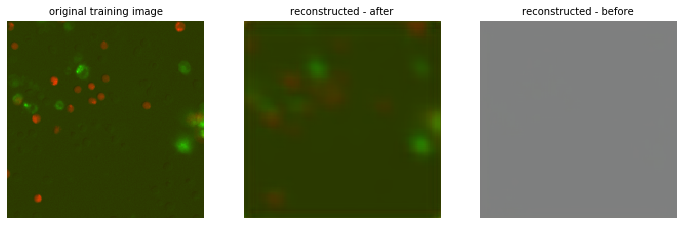

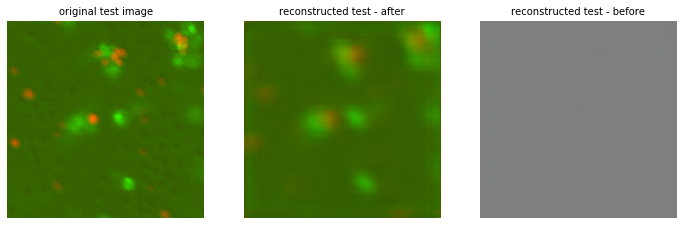

In [25]:
run_evaluation(decoder, x_train[:-200], x_train[-200:], batch_size=64, epochs=10)

In [0]:
encoder = Model(input_img, encoded)
encoded_imgs = encoder.predict(x_train)
encoded = np.reshape(encoded_imgs, (len(encoded_imgs), 24*24*8))

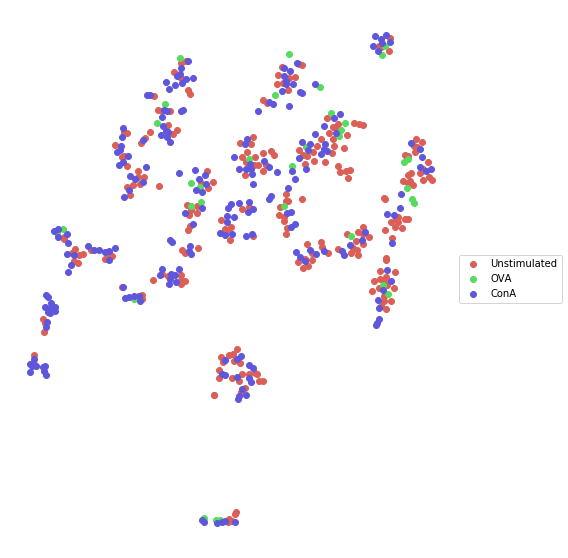

In [28]:
x_tsne = TSNE(random_state=RS, perplexity=5, learning_rate=200, n_iter=2500).fit_transform(encoded[:500])
plot_tsne(x_tsne, y_train[:500])

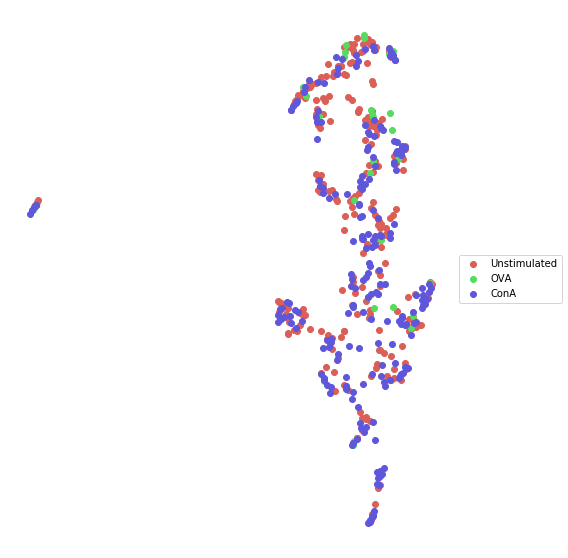

In [29]:
x_umap = umap.UMAP(random_state=RS).fit_transform(encoded[:500])
plot_tsne(x_umap, y_train[:500])

### Image augmentation

In [0]:
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [0]:
train_datagen = ImageDataGenerator(
    rotation_range=360,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
    )
itr = train_datagen.flow(
x_train, y_train,
batch_size=x_train.size)

X, y = itr.next()

In [0]:
x_big = np.concatenate((x_train, X), axis=0)
y_big = np.concatenate((y_train, y), axis=0)

(3336, 192, 192, 1)

### Human visualisation of different drug conditions

In [0]:
encoder = Model(input_img, encoded)

In [0]:
unstimulated = x_combined[y_combined==0]

In [0]:
ova = x_combined[y_combined==1]

In [0]:
cona = x_combined[y_combined==2]

In [0]:
def plot_range(imgs, rn=8):
    fig = plt.figure(figsize=(15, 15))
    for i in range(1, 6):
        ax = fig.add_subplot(1, 5, i)
        plt.imshow(imgs[i+rn])
        ax.axis('off')

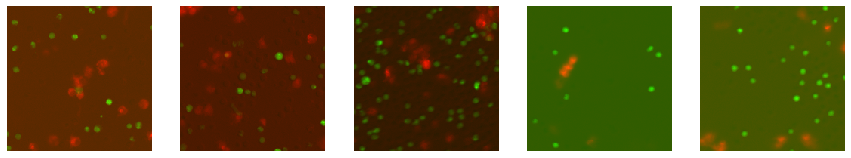

In [0]:
plot_range(unstimulated, rn=9)

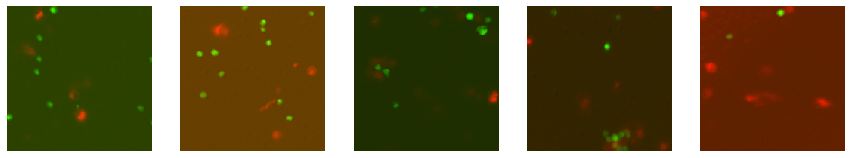

In [0]:
plot_range(ova, rn=9)

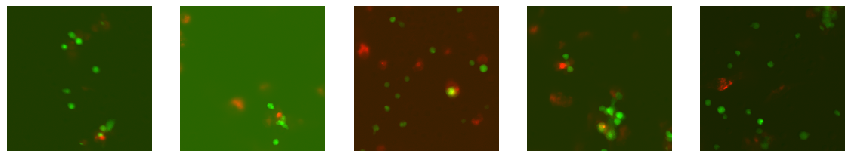

In [0]:
plot_range(cona, rn=9)

### t-sne to gif

In [0]:
# monkey patch gradient descent 
import sklearn

positions = []

def _gradient_descent(objective, p0, it, n_iter,
                      n_iter_check=1, n_iter_without_progress=300,
                      momentum=0.8, learning_rate=200.0, min_gain=0.01,
                      min_grad_norm=1e-7, verbose=0, args=None, kwargs=None):

    if args is None:
        args = []
    if kwargs is None:
        kwargs = {}

    p = p0.copy().ravel()
    update = np.zeros_like(p)
    gains = np.ones_like(p)
    error = np.finfo(np.float).max
    best_error = np.finfo(np.float).max
    best_iter = i = it

    for i in range(it, n_iter):
        positions.append(p.copy())
        
        check_convergence = (i + 1) % n_iter_check == 0
        # only compute the error when needed
        kwargs['compute_error'] = check_convergence or i == n_iter - 1

        error, grad = objective(p, *args, **kwargs)
        grad_norm = linalg.norm(grad)

        inc = update * grad < 0.0
        dec = np.invert(inc)
        gains[inc] += 0.2
        gains[dec] *= 0.8
        np.clip(gains, min_gain, np.inf, out=gains)
        grad *= gains
        update = momentum * update - learning_rate * grad
        p += update

        if check_convergence:

            if verbose >= 2:
                print("[t-SNE] Iteration %d: error = %.7f,"
                      " gradient norm = %.7f"
                      " (%s iterations in %0.3fs)"
                      % (i + 1, error, grad_norm, n_iter_check, duration))

            if error < best_error:
                best_error = error
                best_iter = i
            elif i - best_iter > n_iter_without_progress:
                if verbose >= 2:
                    print("[t-SNE] Iteration %d: did not make any progress "
                          "during the last %d episodes. Finished."
                          % (i + 1, n_iter_without_progress))
                break
            if grad_norm <= min_grad_norm:
                if verbose >= 2:
                    print("[t-SNE] Iteration %d: gradient norm %f. Finished."
                          % (i + 1, grad_norm))
                break

    return p, error, i

sklearn.manifold.t_sne._gradient_descent = _gradient_descent

In [0]:
def scatter_gif(x, colors, labels=["Unstimulated", "OVA", "ConA"]):
    palette = np.array(sns.color_palette("hls", len(labels)))
    colors = np.array(colors)
    
    f = plt.figure(figsize=(8,8))
    ax = plt.subplot()
    
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    return f, sc

In [0]:
from scipy import linalg

from moviepy.video.io.bindings import mplfig_to_npimage
import moviepy.editor as mpy

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1990656/45929032 bytes (4.3%)5898240/45929032 bytes (12.8%)9854976/45929032 bytes (21.5%)13656064/45929032 bytes (29.7%)17547264/45929032 bytes (38.2%)21413888/45929032 bytes (46.6%)25264128/45929032 bytes (55.0%)29179904/45929032 bytes (63.5%)33087488/45929032 bytes (72.0%)36831232/45929032 bytes (80.2%)40640512/45929032 bytes (88.5%)43999232/45929032 bytes (95.8%)

In [0]:
def make_gif(out, x, y, labels=["Unstimulated", "OVA", "ConA"]):
    def make_frame_mpl(t):
        i = int(t*40)
        x = X_iter[..., i]
        sc.set_offsets(x)
        return mplfig_to_npimage(f)

    X_proj = TSNE(random_state=RS).fit_transform(x)
    X_iter = np.dstack(position.reshape(-1, 2) for position in positions)
    
    f, sc = scatter_gif(X_iter[..., -1], y, labels=labels)
    
    animation = mpy.VideoClip(make_frame_mpl,
                          duration=X_iter.shape[2]/40.)
    animation.write_gif(out, fps=20)
    


[MoviePy] Building file /content/gdrive/My Drive/l4_dataset/cluster_combined_1.gif with imageio


100%|█████████▉| 500/501 [01:03<00:00,  7.66it/s]


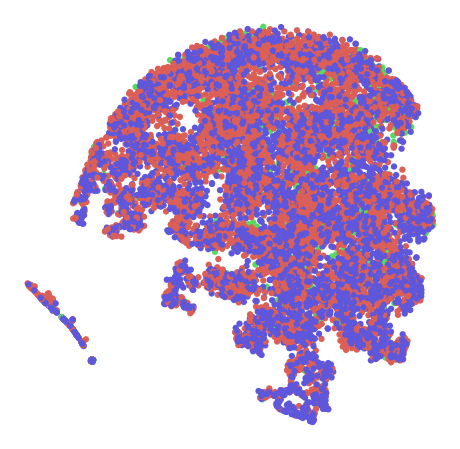

In [0]:
make_gif('/content/gdrive/My Drive/l4_dataset/cluster_combined_1.gif', encoded, y_combined)